# Heart Attack - Kaggle competition  V 2.0

Author: _Aniko Maraz, PhD_

<div class="alert alert-block alert-info">
    
This is an <a href="https://www.kaggle.com/competitions/heart-attack-risk-analysis/overview">active Kaggle competition</a>  for Kudos. <br>    
The task is to predict (on an unseen dataset) if the patient is at low or high risk of heart attack.  <br>

In the current notebook I will preprocess the data, attempt to fit a Logistic Regression, SVM, XGBoost model and a Decision tree for the classification task (with SVM producing the best accuracy) using pipelines. This has got me place 46 in the open competition (improvement of 10 places compared to V 1.0!). <br>

</div>

## Imports

In [83]:
import numpy as np
import pandas as pd
from dataprep.eda import create_report

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import jupyter_black
import warnings

%load_ext jupyter_black
%matplotlib inline

warnings.filterwarnings("ignore")  # for final notebook

# Display all columns in the DataFrame throughout the Notebook
pd.set_option("display.max_columns", None)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## DATA: GET AND EXPLORE

In [88]:
df_raw_train = pd.read_csv("data/train.csv")
df_raw_train.shape

(7010, 26)

In [89]:
df_raw_train.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,RDG0550,33,Male,200,129/90,48,0,1,1,1,1,7.807690,Unhealthy,0,1,2,0.138443,184066,30.449815,63,6,7,Argentina,South America,Southern Hemisphere,1
1,NMA3851,56,Female,262,159/105,46,1,0,1,0,0,17.297628,Average,1,0,8,0.369552,211755,34.973685,333,7,8,Nigeria,Africa,Northern Hemisphere,1
2,TUI5807,19,Female,140,161/109,54,0,1,0,0,1,8.695288,Average,1,1,3,8.646334,252203,30.554246,537,2,10,Thailand,Asia,Northern Hemisphere,0
3,YYT5016,50,Female,163,120/62,53,0,1,1,1,1,10.161587,Healthy,0,1,7,1.107884,121954,35.390265,591,0,9,Spain,Europe,Southern Hemisphere,1
4,ZAC5937,89,Female,144,153/110,92,1,0,1,0,1,16.436787,Healthy,1,0,1,1.337570,180121,39.575483,145,2,5,Germany,Europe,Northern Hemisphere,1


In [90]:
report = create_report(df_raw_train)
# report.save('report_heart_attack')

  0%|                                                  | 0/3307 [00:00<?, ?it/s]

The [statistical description of features](https://github.com/anikomaraz/heart_attack_kaggle/blob/main/report_heart_attack.html) is available in V 1.0 of the notebook. Features' data contain no missing values or outliers, most features are close to normal distribution, classes contain approximately the same data points. There are 7010 rows (patients) and 25 features. 

## PREPROCESSING PIPELINE

In [91]:
# def function to split blood pressure data (current format: 129/90)
def split_blood_pressure(df):
    df[["Systolic", "Diastolic"]] = df["Blood Pressure"].str.split("/", expand=True)
    df["Systolic"] = pd.to_numeric(df["Systolic"])
    df["Diastolic"] = pd.to_numeric(df["Diastolic"])
    df.drop(columns=["Blood Pressure"], inplace=True)


# split cholesterol according to sample mean
cholesterol_sample_mean = df_raw_train["Cholesterol"].mean()


def split_cholesterol_sample(df):
    df["Cholesterol_sample_split"] = np.where(
        df["Cholesterol"] > cholesterol_sample_mean, 1, 0
    )


# total excercise
def exercise_total(df):
    df["Exercise Total"] = (
        df["Exercise Hours Per Week"] * df["Physical Activity Days Per Week"]
    )


# construct the ratio of systolic and diastolic blood pressure
def systolic_diastolic_ratio_constructor(df):
    df["Systolic_Diastolic_Ratio"] = df["Systolic"] / df["Diastolic"]


# create the new variables
df = df_raw_train.copy()

split_blood_pressure(df=df)
split_cholesterol_sample(df=df)
exercise_total(df=df)
systolic_diastolic_ratio_constructor(df=df)

### Define features

In [95]:
# Defining the features and the target
X = df.drop(columns="Heart Attack Risk")
y = df["Heart Attack Risk"]

In [96]:
# Opt-in continuous and categorical variables
continuous_vars = [
    "Age",
    "Cholesterol",
    "Heart Rate",
    # "Exercise Hours Per Week",
    "Stress Level",
    "Sedentary Hours Per Day",
    "Income",
    "BMI",
    "Triglycerides",
    # "Physical Activity Days Per Week",
    "Sleep Hours Per Day",
    # "Systolic",
    # "Diastolic",
    "Exercise Total",
    "Systolic_Diastolic_Ratio",
]

categorical_vars = [
    "Diabetes",
    "Family History",
    "Obesity",
    "Alcohol Consumption",
    "Previous Heart Problems",
    "Medication Use",
    # "Cholesterol_sample_split",
    "Smoking",
    "Sex",
    "Continent",
    "Diet",
    "Hemisphere",
    # "Country",
]

X_selected = X[continuous_vars + categorical_vars]

### Create preprocessing pipeline and train/test data

In [97]:
# Define preprocessing steps for continuous and categorical features
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop="first")

preproc_basic = ColumnTransformer(
    transformers=[
        ("num", num_transformer, continuous_vars),
        ("cat", cat_transformer, categorical_vars),
    ],
    remainder="passthrough",
)

# Create pipelines for each classifier
logistic_regression_pipe = make_pipeline(
    preproc_basic, LogisticRegression(random_state=6)
)
svm_pipe = make_pipeline(preproc_basic, SVC(random_state=6))
xgboost_pipe = make_pipeline(preproc_basic, XGBClassifier(random_state=6))
decision_tree_pipe = make_pipeline(
    preproc_basic, DecisionTreeClassifier(random_state=6)
)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=6
)

In [10]:
preproc_basic

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Age', 'Cholesterol', 'Heart Rate',
                                  'Exercise Hours Per Week', 'Stress Level',
                                  'Sedentary Hours Per Day', 'Income', 'BMI',
                                  'Triglycerides',
                                  'Physical Activity Days Per Week',
                                  'Sleep Hours Per Day', 'Systolic',
                                  'Diastolic', 'Exercise Total',
                                  'Systolic_Diastolic_Ratio']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['Diabetes', 'Family History', 'Obesity',
                                  'Alcohol Consumption',
                                  'Previous Heart Problems', 'Medication Use',
                                  'Cholesterol_sample_split', 'Smoking', 'Sex',
                                  'Continent', 'Diet', 'Hemisphere',
                                  'Country'])])

## FIT and EVALUATE pipeline with competing classification models

In [109]:
pipes = [logistic_regression_pipe, svm_pipe, xgboost_pipe, decision_tree_pipe]

for pipe in pipes:
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)

# Cross-validate each pipeline
for pipe, name in [
    (logistic_regression_pipe, "Logistic Regression"),
    (svm_pipe, "SVM"),
    (xgboost_pipe, "XGBoost"),
    (decision_tree_pipe, "Decision Tree"),
]:
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy").mean()
    print(f"Cross-validated accuracy for {name}: {cv_score}")

Cross-validated accuracy for Logistic Regression: 0.6421437038974737
Cross-validated accuracy for SVM: 0.6423475774958426
Cross-validated accuracy for XGBoost: 0.5885486151335663
Cross-validated accuracy for Decision Tree: 0.5490079328006046


In [26]:
# Fit preprocessing on the entire dataset
X_preprocessed = preproc_basic.fit_transform(X_selected)

# Convert the transformed data to a DataFrame
X_train_preprocessed_df = pd.DataFrame(
    X_preprocessed,
    columns=continuous_vars
    + list(
        preproc_basic.named_transformers_["cat"].get_feature_names_out(categorical_vars)
    ),
)

### Check features' distribution

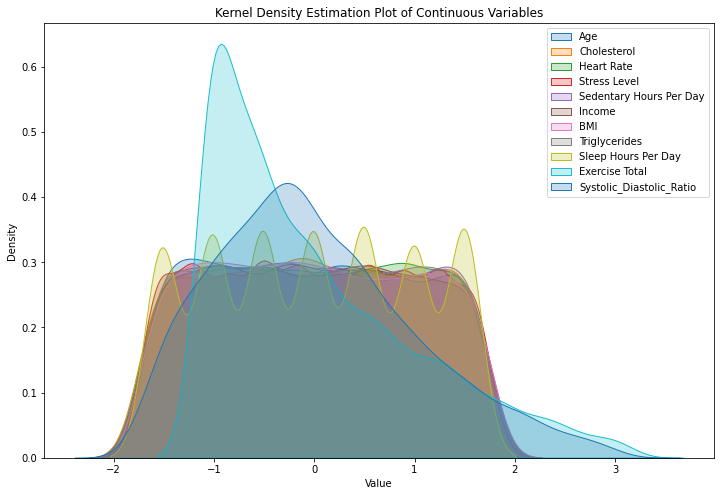

In [27]:
# Select only the continuous variables
number_of_features = len(continuous_vars)
continuous_data = X_train_preprocessed_df.iloc[:, :number_of_features]
continuous_df = pd.DataFrame(continuous_data, columns=continuous_vars)

# Plot KDE for each continuous variable
plt.figure(figsize=(12, 8))
for column in continuous_df.columns:
    sns.kdeplot(continuous_df[column], label=column, shade=True)

plt.title("Kernel Density Estimation Plot of Continuous Variables")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

Because of the one-hot-encoding all categorical features now take 2 values (0 or 1), so I will stack them accordingly.

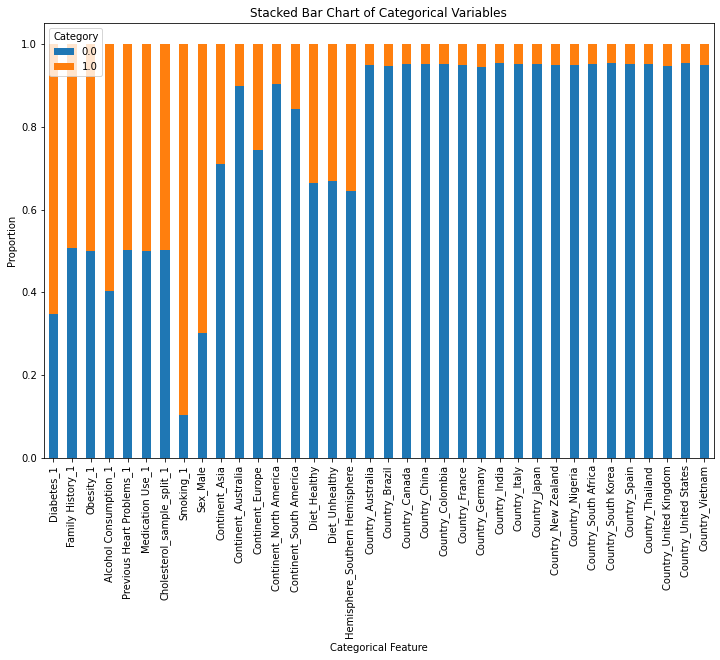

In [17]:
# Select categorical features
continuous_feature_count = len(continuous_vars)
categorical_data = X_train_preprocessed_df.iloc[:, continuous_feature_count:]

categorical_df = pd.DataFrame(categorical_data)

# Aggregate counts for the plot
proportions_df = categorical_df.apply(lambda x: x.value_counts(normalize=True)).T

# Plot stacked bar chart
proportions_df.plot(kind="bar", stacked=True, figsize=(12, 8))

plt.title("Stacked Bar Chart of Categorical Variables")
plt.xlabel("Categorical Feature")
plt.ylabel("Proportion")
plt.legend(title="Category")
plt.show()

## PREDICT

In [106]:
df_kaggle_test = pd.read_csv("data/test.csv")  # read in test data provided by Kaggle

In [107]:
# preprocess Kaggle data
df_kaggle_test = df_kaggle_test.copy()

split_blood_pressure(df=df_kaggle_test)
split_cholesterol_sample(df=df_kaggle_test)
exercise_total(df=df_kaggle_test)
systolic_diastolic_ratio_constructor(df=df_kaggle_test)

X_df_kaggle_test_selected = df_kaggle_test[continuous_vars + categorical_vars]

In [108]:
# Define preprocessing steps for continuous and categorical features
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop="first")

# Create preprocessing pipeline
preproc_basic = ColumnTransformer(
    transformers=[
        ("num", num_transformer, continuous_vars),
        ("cat", cat_transformer, categorical_vars),
    ],
    remainder="passthrough",
)

# Create SVM pipeline
svm_pipe = Pipeline(
    [("preprocessor", preproc_basic), ("classifier", SVC(random_state=6))]
)

# Train the SVM model on the entire preprocessed training dataset
svm_pipe.fit(X_selected, y)

# Make predictions on the df_kaggle_test data
kaggle_test_predictions_V2 = svm_pipe.predict(X_df_kaggle_test_selected)
kaggle_test_predictions_V2

array([0, 0, 0, ..., 0, 0, 0])

### Prepare submission

In [80]:
df_kaggle_predicted_V2 = {
    "Patient ID": df_kaggle_test["Patient ID"],
    "Heart Attack Risk": kaggle_test_predictions_V2,
}
# predict_df = pd.DataFrame(df_kaggle_preprocessed.index, kaggle_test_predictions)
df_kaggle_predicted_V2 = pd.DataFrame(df_kaggle_predicted_V2)
df_kaggle_predicted_V2

,Patient ID,Heart Attack Risk
0,BMW7812,0
1,XXM0972,0
2,RQX1211,0
3,RVN4963,0
4,NCU1956,0
...,...,...
1748,GQZ5013,0
1749,FDK8693,0
1750,SVO4635,0
1751,KQR8949,0


In [81]:
df_kaggle_predicted_V2.to_csv("submission/df_kaggle_predicted_V2.csv", index=False)

## Evaluation on Kaggle

And this fired me to place 46!

![second submission](submission/second_submission.png)